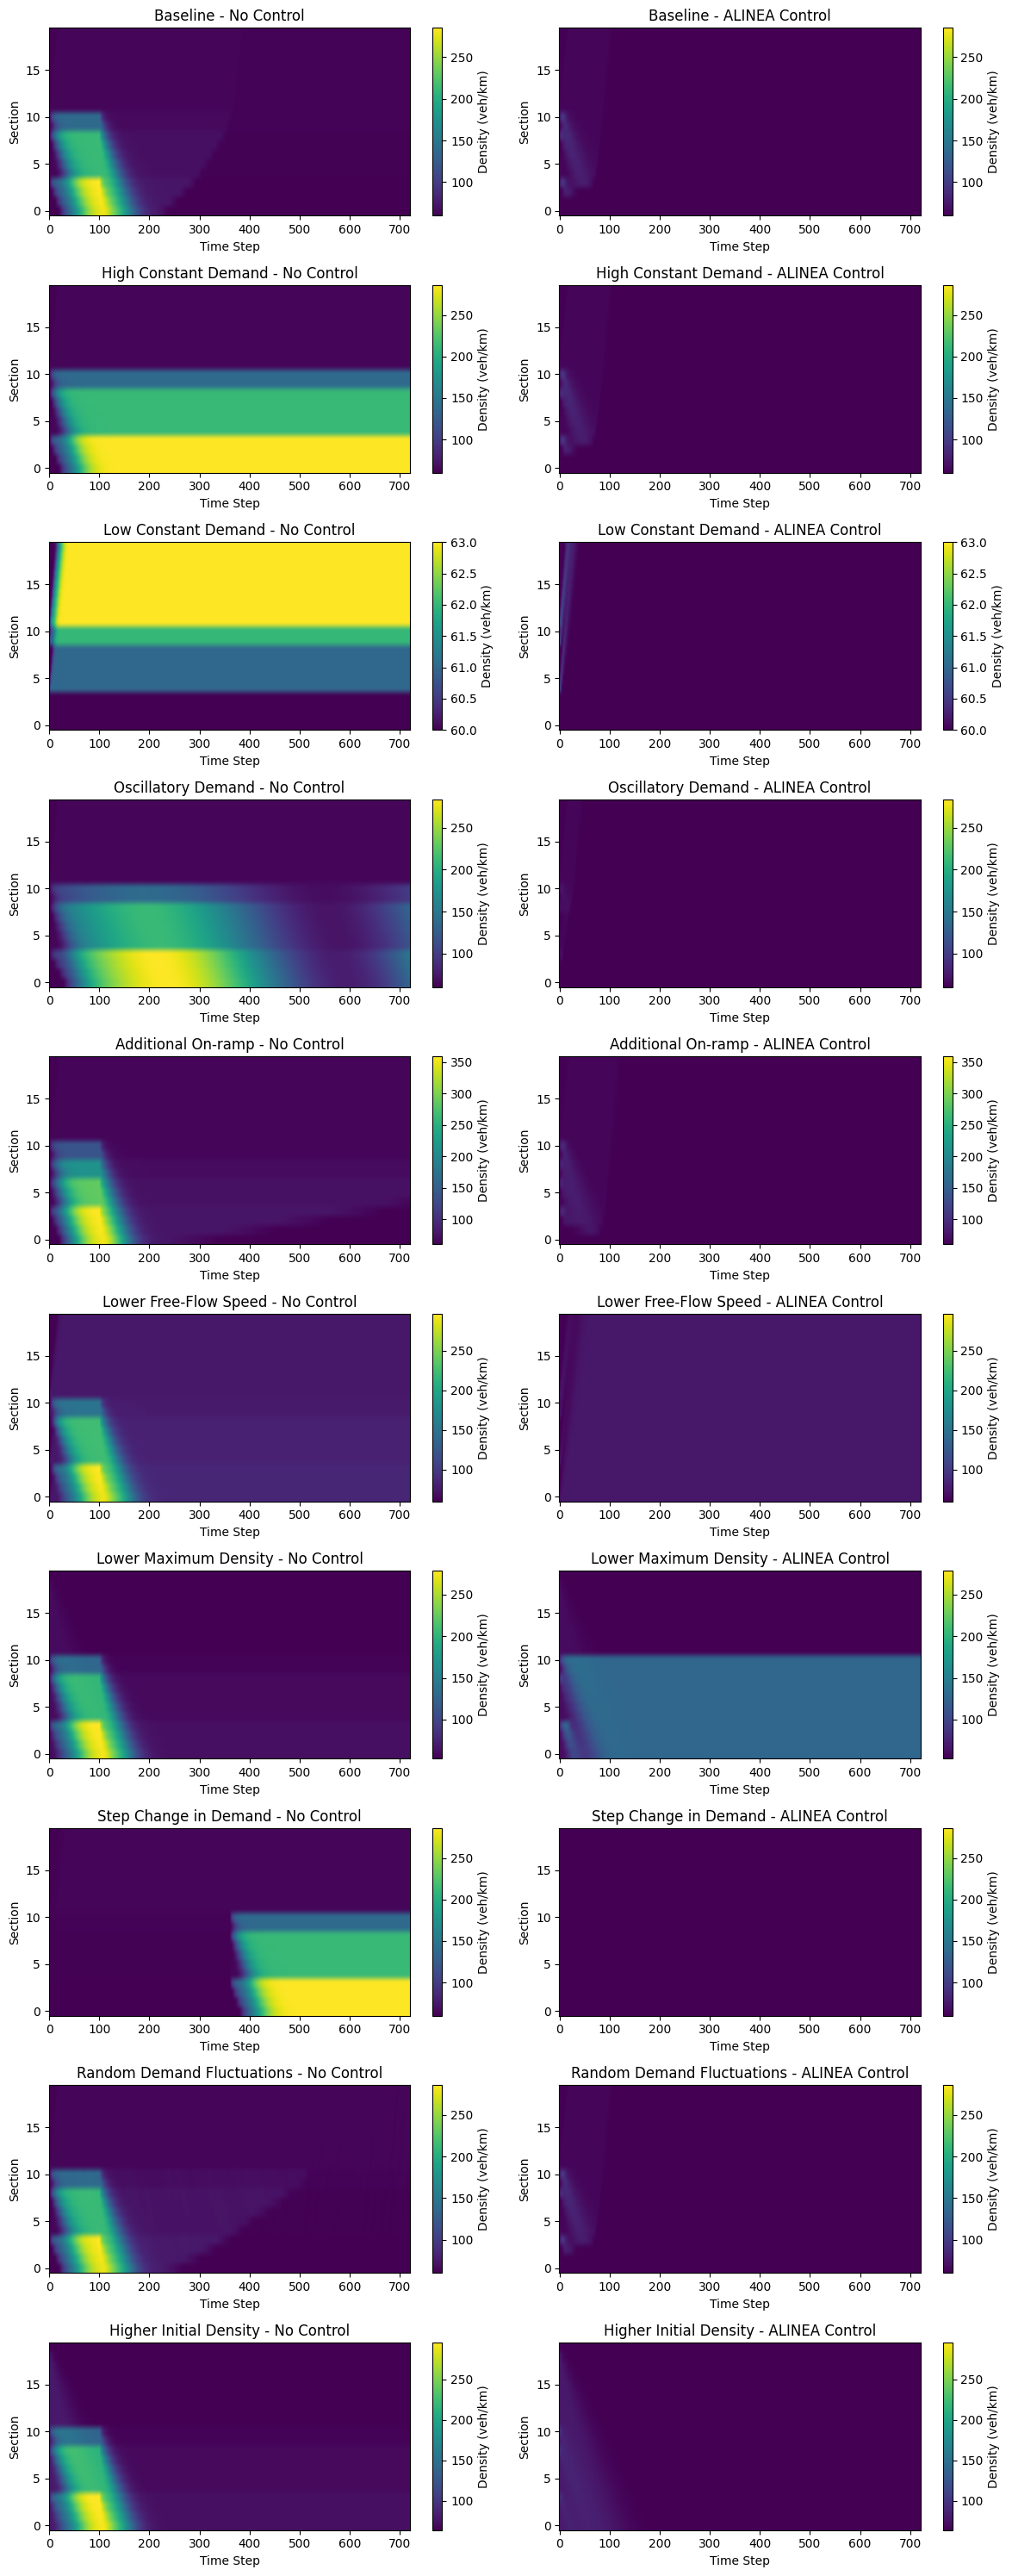

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Helper Function: Generate Demand
# -----------------------------
def generate_demand(demand_type, K, ramp_indices, ramp_value_high, ramp_value_low, N):
    """
    Generates a demand matrix of shape (N, K) for on-ramp sections.
    
    For non on-ramp sections, demand remains zero.
    If ramp_value_low is None, then for each on-ramp:
      if index==11 (MATLAB section 12) then low=50 else low=100.
    """
    dem = np.zeros((N, K))
    # Determine default low values if not provided.
    if ramp_value_low is None:
        ramp_low_dict = {i: (50 if i == 11 else 100) for i in ramp_indices}
    else:
        ramp_low_dict = {i: ramp_value_low for i in ramp_indices}
    
    if demand_type == "baseline":
        # First 100 time steps: high demand; later: low demand.
        for k in range(100):
            for i in ramp_indices:
                dem[i, k] = ramp_value_high
        for k in range(100, K):
            for i in ramp_indices:
                dem[i, k] = ramp_low_dict[i]
    elif demand_type == "high_constant":
        for k in range(K):
            for i in ramp_indices:
                dem[i, k] = ramp_value_high
    elif demand_type == "low_constant":
        for k in range(K):
            for i in ramp_indices:
                dem[i, k] = ramp_low_dict[i]
    elif demand_type == "oscillatory":
        # Oscillatory between low and high.
        for k in range(K):
            demand_val = ramp_low_dict[ramp_indices[0]] + (ramp_value_high - ramp_low_dict[ramp_indices[0]]) * 0.5 * (1 + np.sin(2 * np.pi * k / K))
            for i in ramp_indices:
                dem[i, k] = demand_val
    elif demand_type == "step_change":
        # First half low, then high.
        for k in range(K):
            for i in ramp_indices:
                if k < K // 2:
                    dem[i, k] = ramp_low_dict[i]
                else:
                    dem[i, k] = ramp_value_high
    elif demand_type == "random":
        # Baseline pattern with random fluctuations.
        for k in range(100):
            for i in ramp_indices:
                baseline = ramp_value_high
                noise = np.random.normal(0, 100)
                dem[i, k] = max(0, baseline + noise)
        for k in range(100, K):
            for i in ramp_indices:
                baseline = ramp_low_dict[i]
                noise = np.random.normal(0, 50)
                dem[i, k] = max(0, baseline + noise)
    else:
        # Default to baseline.
        for k in range(100):
            for i in ramp_indices:
                dem[i, k] = ramp_value_high
        for k in range(100, K):
            for i in ramp_indices:
                dem[i, k] = ramp_low_dict[i]
    return dem

# -----------------------------
# Helper Function: Run Simulation
# -----------------------------
def run_simulation(N, K, T, L, rho_max, vf, w, rho_iniz, fi_iniz, rho_sez0, fi_sez0, rho_sezfin, fi_sezfin, dem, Ir, K_alinea, rho_ref, r_max_control):
    """
    Runs both the No Control (open-loop) and ALINEA Control (closed-loop) simulations.
    Returns the density matrices for each case.
    """
    # --- No Control Simulation ---
    rho_nc = np.zeros((N, K + 1))
    fi_nc = np.zeros((N, K + 1))
    r_nc = dem.copy()  # Ramp flows follow the demand exactly.
    
    # Initialize densities at time 0 using the given initial conditions.
    for i in range(N - 1):
        rho_nc[i, 0] = rho_iniz[i] + T / L[i] * (fi_iniz[i] - fi_iniz[i + 1])
    rho_nc[N - 1, 0] = rho_iniz[N - 1] + T / L[N - 1] * (fi_iniz[N - 1] - vf[N - 1] * rho_iniz[N - 1])
    
    for k in range(K):
        fi_nc[0, k] = min(fi_sez0[k], w[0] * (rho_max[0] - rho_nc[0, k]) - r_nc[0, k])
        for i in range(1, N):
            fi_nc[i, k] = min(vf[i - 1] * rho_nc[i - 1, k], w[i] * (rho_max[i] - rho_nc[i, k]) - r_nc[i, k])
        for i in range(N - 1):
            rho_nc[i, k + 1] = rho_nc[i, k] + T / L[i] * (fi_nc[i, k] + r_nc[i, k] - fi_nc[i + 1, k])
        fi_sezfin_nc = min(vf[N - 1] * rho_nc[N - 1, k], fi_sezfin[k])
        rho_nc[N - 1, k + 1] = rho_nc[N - 1, k] + T / L[N - 1] * (fi_nc[N - 1, k] + r_nc[N - 1, k] - fi_sezfin_nc)
    
    # --- ALINEA Control Simulation ---
    rho_al = np.zeros((N, K + 1))
    fi_al = np.zeros((N, K + 1))
    r_al = dem.copy()  # Will be updated by the ALINEA control law.
    
    for i in range(N - 1):
        rho_al[i, 0] = rho_iniz[i] + T / L[i] * (fi_iniz[i] - fi_iniz[i + 1])
    rho_al[N - 1, 0] = rho_iniz[N - 1] + T / L[N - 1] * (fi_iniz[N - 1] - vf[N - 1] * rho_iniz[N - 1])
    
    for k in range(K):
        # ALINEA control update for on-ramp sections.
        for i in range(N):
            if Ir[i] == 1 and k > 0:
                r_al[i, k] = r_al[i, k - 1] + K_alinea * (rho_ref - rho_al[i, k])
                r_al[i, k] = np.clip(r_al[i, k], 0, r_max_control)
        fi_al[0, k] = min(fi_sez0[k], w[0] * (rho_max[0] - rho_al[0, k]) - r_al[0, k])
        for i in range(1, N):
            fi_al[i, k] = min(vf[i - 1] * rho_al[i - 1, k], w[i] * (rho_max[i] - rho_al[i, k]) - r_al[i, k])
        for i in range(N - 1):
            rho_al[i, k + 1] = rho_al[i, k] + T / L[i] * (fi_al[i, k] + r_al[i, k] - fi_al[i + 1, k])
        fi_sezfin_al = min(vf[N - 1] * rho_al[N - 1, k], fi_sezfin[k])
        rho_al[N - 1, k + 1] = rho_al[N - 1, k] + T / L[N - 1] * (fi_al[N - 1, k] + r_al[N - 1, k] - fi_sezfin_al)
    
    return rho_nc, rho_al

# -----------------------------
# Global Simulation Parameters (default)
# -----------------------------
N = 20
K = 360 * 2         # 2 hours simulation (with 10-s sampling)
T = 10 / 3600       # 10 seconds expressed in hours
L = np.full(N, 0.5) # Section lengths (km)
w = np.full(N, 27)  # Congested wave speed

# Default boundary conditions (first and last section)
default_rho_sez0_val = 60
default_rho_sezfin_val = 80

# -----------------------------
# ALINEA Control Parameters (common for all scenarios)
# -----------------------------
K_alinea = 50         # ALINEA gain (vehicles/h per (veh/km))
rho_ref = 60          # Target mainline density (veh/km)
r_max_control = 2000  # Maximum ramp metering rate (vehicles/h)

# -----------------------------
# Scenario Definitions
# -----------------------------
scenarios = [
    {"name": "Baseline",
     "demand_type": "baseline",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,   # Use default: index 11 gets 50, others 100
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "High Constant Demand",
     "demand_type": "high_constant",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": 2000,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Low Constant Demand",
     "demand_type": "low_constant",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 100,
     "ramp_value_low": 100,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Oscillatory Demand",
     "demand_type": "oscillatory",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": 100,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Additional On-ramp",
     "demand_type": "baseline",
     "ramp_indices": [4, 7, 9, 11],  # Extra on-ramp added (index 7)
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Lower Free-Flow Speed",
     "demand_type": "baseline",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 60,
     "vf": 80,      # Lower free-flow speed
     "rho_max": 300},
    
    {"name": "Lower Maximum Density",
     "demand_type": "baseline",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 250},  # Lower maximum density
    
    {"name": "Step Change in Demand",
     "demand_type": "step_change",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": 100,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Random Demand Fluctuations",
     "demand_type": "random",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": 100,
     "rho_iniz": 60,
     "vf": 100,
     "rho_max": 300},
    
    {"name": "Higher Initial Density",
     "demand_type": "baseline",
     "ramp_indices": [4, 9, 11],
     "ramp_value_high": 2000,
     "ramp_value_low": None,
     "rho_iniz": 80,             # Higher initial density
     "vf": 100,
     "rho_max": 300,
     "rho_sez0": 80,             # Also modify boundary conditions accordingly
     "rho_sezfin": 80}
]

# -----------------------------
# Loop Over Scenarios and Run Simulations
# -----------------------------
# Store results for plotting.
results = []  # Each element will be a dictionary with scenario name and simulation results.

for scenario in scenarios:
    # Use scenario-specific parameters or default values.
    rho_iniz_val = scenario.get("rho_iniz", 60)
    rho_iniz = np.full(N, rho_iniz_val)
    fi_iniz = rho_iniz * 100
    
    # Boundary conditions (first and last section).
    rho_sez0_val = scenario.get("rho_sez0", default_rho_sez0_val)
    rho_sezfin_val = scenario.get("rho_sezfin", default_rho_sezfin_val)
    rho_sez0 = np.full(K, rho_sez0_val)
    fi_sez0 = rho_sez0 * 100
    rho_sezfin = np.full(K, rho_sezfin_val)
    fi_sezfin = rho_sezfin * 100
    
    # Traffic parameters (vf, rho_max, w remain arrays of length N).
    vf_val = scenario.get("vf", 100)
    vf_arr = np.full(N, vf_val)
    rho_max_val = scenario.get("rho_max", 300)
    rho_max_arr = np.full(N, rho_max_val)
    
    # On-ramp indicator vector: set ones for the specified ramp indices.
    ramp_indices = scenario["ramp_indices"]
    Ir = np.zeros(N)
    for i in ramp_indices:
        Ir[i] = 1
    
    # Generate the demand matrix.
    dem = generate_demand(
        demand_type=scenario["demand_type"],
        K=K,
        ramp_indices=ramp_indices,
        ramp_value_high=scenario["ramp_value_high"],
        ramp_value_low=scenario["ramp_value_low"],
        N=N
    )
    
    # Run both simulations.
    rho_nc, rho_al = run_simulation(N, K, T, L, rho_max_arr, vf_arr, w, 
                                      rho_iniz, fi_iniz, rho_sez0, fi_sez0, 
                                      rho_sezfin, fi_sezfin, dem, Ir, 
                                      K_alinea, rho_ref, r_max_control)
    
    results.append({
        "name": scenario["name"],
        "rho_nc": rho_nc,
        "rho_al": rho_al
    })

# -----------------------------
# Plotting: 10 Scenarios, Each with 2 Plots (No Control and ALINEA)
# -----------------------------
n_scenarios = len(results)
fig, axes = plt.subplots(n_scenarios, 2, figsize=(12, 3 * n_scenarios))
if n_scenarios == 1:
    axes = np.array([axes])  # ensure axes is 2D if only one scenario

for idx, res in enumerate(results):
    # Compute common color limits for this scenario.
    global_min = min(np.min(res["rho_nc"]), np.min(res["rho_al"]))
    global_max = max(np.max(res["rho_nc"]), np.max(res["rho_al"]))
    
    # No Control plot.
    im0 = axes[idx, 0].imshow(res["rho_nc"], aspect='auto', origin='lower',
                                vmin=global_min, vmax=global_max)
    axes[idx, 0].set_title(f'{res["name"]} - No Control')
    axes[idx, 0].set_xlabel('Time Step')
    axes[idx, 0].set_ylabel('Section')
    fig.colorbar(im0, ax=axes[idx, 0], label='Density (veh/km)')
    
    # ALINEA Control plot.
    im1 = axes[idx, 1].imshow(res["rho_al"], aspect='auto', origin='lower',
                                vmin=global_min, vmax=global_max)
    axes[idx, 1].set_title(f'{res["name"]} - ALINEA Control')
    axes[idx, 1].set_xlabel('Time Step')
    axes[idx, 1].set_ylabel('Section')
    fig.colorbar(im1, ax=axes[idx, 1], label='Density (veh/km)')

plt.tight_layout()
plt.show()
